In [1]:
import numpy as np
import pandas as pd
import os

# 1.1 Call sklearn libraries

# 1.1.1 Split data into train and test data
from sklearn.model_selection import train_test_split

# 1.1.2 PReprocessong:
from sklearn.preprocessing import StandardScaler

# 1.1.3 Import class DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier as dtree

# 1.1.4 To draw decision tree
from sklearn.tree import export_graphviz

# 1.1.5 Import iris
from sklearn.datasets import load_iris

# 1.1.6
# Install as:
#   conda install -c conda-forge python-graphviz 
#   conda install -c anaconda pydot
import graphviz

# 1.1.7
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [14]:
import seaborn as sns

In [4]:
from google.colab import files
uploaded = files.upload()

Saving german_credit_data.csv to german_credit_data.csv


In [5]:
df = pd.read_csv("german_credit_data.csv")

In [6]:
df.head()

Unnamed: 0  Age     Sex  ...  Duration              Purpose  Risk
0           0   67    male  ...         6             radio/TV  good
1           1   22  female  ...        48             radio/TV   bad
2           2   49    male  ...        12            education  good
3           3   45    male  ...        42  furniture/equipment  good
4           4   53    male  ...        24                  car   bad

[5 rows x 11 columns]

In [7]:
df.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [8]:
df.shape

(1000, 11)

In [11]:
df.Housing.unique()

array(['own', 'free', 'rent'], dtype=object)

In [12]:
df.Purpose.unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

Text(0.5, 1.0, 'Correlation Factors Heat Map')

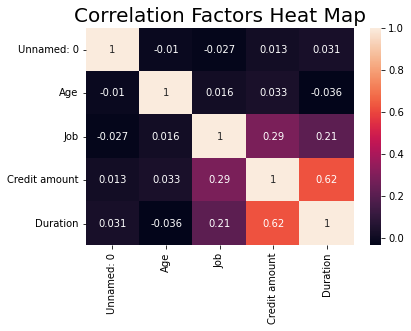

In [17]:
#to see the correaltion between the various variables
sns.heatmap(df.corr(), annot=True).set_title('Correlation Factors Heat Map', color='black', size='20')

In [18]:
df['Job'].value_counts()

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

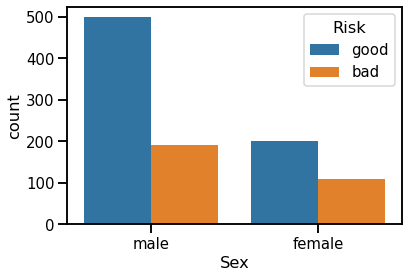

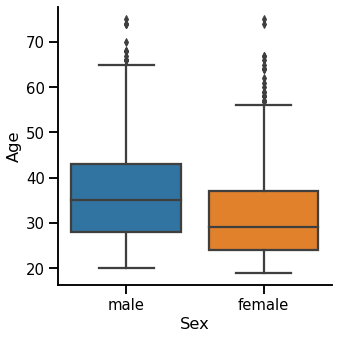

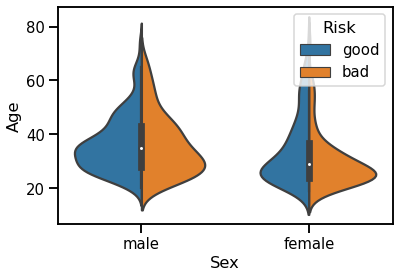

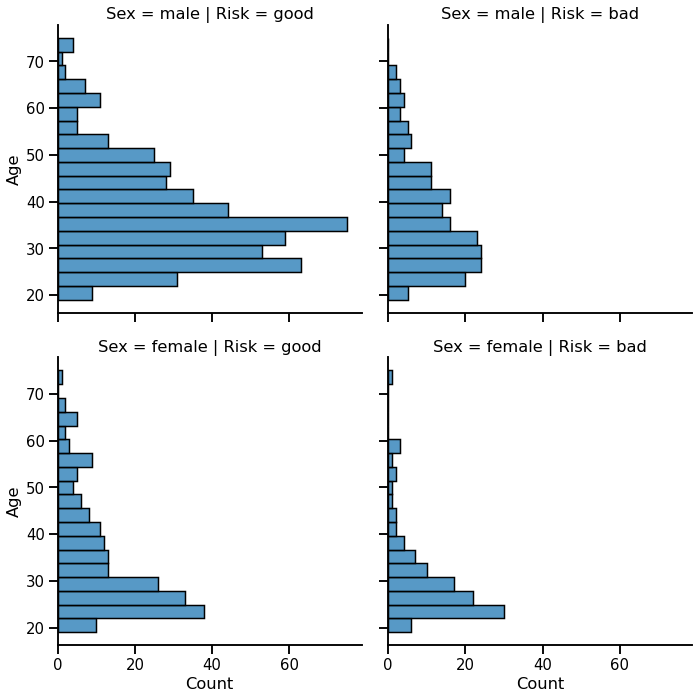

In [20]:
sns.set_context('talk', font_scale=.9)
# Example of types of analysis that can be done

# Count plot helps us visualize the number of elements per category
sns.countplot(data=df, x='Sex', hue='Risk')
plt.show()

# Box plot helps us see the mean value of a category "Sex" per "Age" in our dataset
sns.catplot(data=df, x='Sex', y='Age', kind='box')
plt.show()

# Split violin plots help us contrast the distribution across a hue value "Risk"
sns.violinplot(data=df, x='Sex', y='Age', hue='Risk', split=True)
plt.show()

# Displot help us visualize the distribution with histograms
sns.displot(data=df, row='Sex', y='Age', col='Risk')
plt.show()

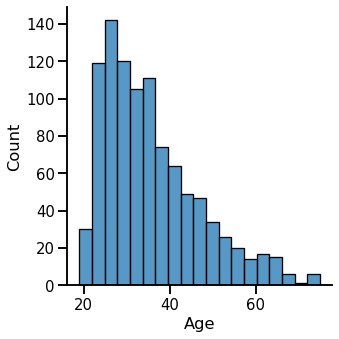

In [22]:
# Let's see how age is distributed
sns.displot(df['Age'])
plt.show()

#Let us split age into categories
interval = (18, 25, 35, 60, 120)
cats = ['Young Adult', 'Adult', 'Senior', 'Elder']
df["Age_cat"] = pd.cut(df['Age'], interval, labels=cats)

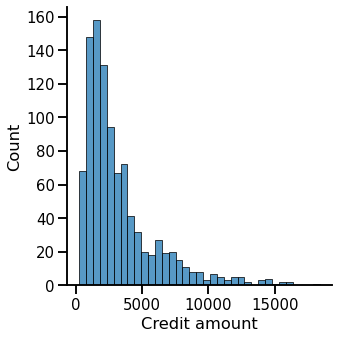

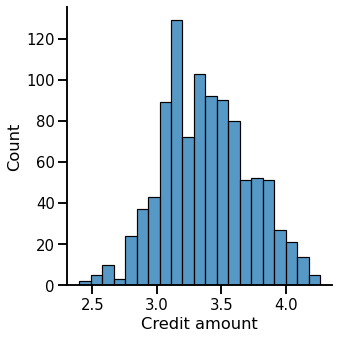

In [24]:
# Let's see how is credit amount distributed
sns.displot(df['Credit amount'])
plt.show()

# Another way to represent long tail numerical distributions is to transform them
# using e.g., a log function
sns.displot(np.log10(df['Credit amount']))
plt.show()

# Apply the new distribution to the dataset
df['Credit amount'] = np.log10(df['Credit amount'])

In [25]:
df['Saving accounts'] = df['Saving accounts'].fillna('no_inf')
df['Checking account'] = df['Checking account'].fillna('no_inf')

for missing values above code is as there were around 400 rows with null values this is a large number as compared to the shape of the dataset.

In [26]:
def one_hot_encoder(df, column_name, exclude_col = False):
    merged_df = df.merge(pd.get_dummies(df[column_name], drop_first=False, prefix=column_name), left_index=True, right_index=True)
    if exclude_col:
        del merged_df[column_name] # Exclude the original column
    return merged_df

In [28]:
df.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk',
       'Age_cat'],
      dtype='object')

In [29]:
df = df.drop('Unnamed: 0', axis='columns')
df.head()

Age     Sex  Job Housing  ... Duration              Purpose  Risk      Age_cat
0   67    male    2     own  ...        6             radio/TV  good        Elder
1   22  female    2     own  ...       48             radio/TV   bad  Young Adult
2   49    male    1     own  ...       12            education  good       Senior
3   45    male    2    free  ...       42  furniture/equipment  good       Senior
4   53    male    2    free  ...       24                  car   bad       Senior

[5 rows x 11 columns]

In [30]:
df_ready = df.copy()


category_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk'] #'Age_cat']

# Note to DIEGO: Uncomment this line of code to include the age category
category_features = ['Job','Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk', 'Age_cat']

for cat in category_features:
    df_ready = one_hot_encoder(df_ready, cat, exclude_col=True)

In [31]:
df_ready.columns

Index(['Age', 'Credit amount', 'Duration', 'Job_0', 'Job_1', 'Job_2', 'Job_3',
       'Sex_female', 'Sex_male', 'Housing_free', 'Housing_own', 'Housing_rent',
       'Saving accounts_little', 'Saving accounts_moderate',
       'Saving accounts_no_inf', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_no_inf',
       'Checking account_rich', 'Purpose_business', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Risk_bad', 'Risk_good',
       'Age_cat_Young Adult', 'Age_cat_Adult', 'Age_cat_Senior',
       'Age_cat_Elder'],
      dtype='object')

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dataset_ready_x = df_ready.drop(['Risk_bad', 'Risk_good', 'Age', 'Sex_male'], axis='columns')
X = dataset_ready_x.values
feature_names = dataset_ready_x.columns

y = df_ready['Risk_bad'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

In [39]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, f1_score, precision_score, recall_score
ct = dtree(
           criterion="gini",    # Alternative 'entropy'
           max_depth=None       # Alternative, specify an integer
                              # 'None' means full tree till single leaf
           )
scoring_type = 'accuracy'
kfold = KFold(n_splits=5, random_state=42, shuffle=True) # Ensuring all methods are evaluated on the same fold

score = cross_val_score(ct, X_train, y_train, cv=kfold, scoring=scoring_type)
print(f'Average {scoring_type} performance of the {ct} model = {np.mean(score)}')

Average accuracy performance of the DecisionTreeClassifier() model = 0.6414285714285715


We are getting accuarcy as 64% which can be increased by using RandomForest Classifier

In [43]:
ct.fit(X_train, y_train)
y_pred = ct.predict(X_test)
# 4.0 Make predictions of test data

# Check the obtained results
print(f"Accuracy of our model's prediction {np.sum((y_test == y_pred))/y_test.size}")

Accuracy of our model's prediction 0.6533333333333333


In [44]:
fi = ct.feature_importances_
fi

array([0.29494212, 0.16757645, 0.01189934, 0.02459991, 0.0139188 ,
       0.03195764, 0.01414236, 0.01350899, 0.01495038, 0.01524152,
       0.02497314, 0.02312962, 0.01197668, 0.01342191, 0.00172256,
       0.0193953 , 0.01141967, 0.09066094, 0.00852669, 0.02010262,
       0.03920305, 0.        , 0.00676625, 0.01224053, 0.0197317 ,
       0.01382183, 0.        , 0.01454491, 0.02403713, 0.03080779,
       0.01078017])

In [45]:
list(zip(df.columns, fi))

[('Age', 0.29494212182816965),
 ('Sex', 0.16757644947983732),
 ('Job', 0.011899335464733244),
 ('Housing', 0.024599913363202826),
 ('Saving accounts', 0.013918799962320169),
 ('Checking account', 0.031957642146788416),
 ('Credit amount', 0.014142359999603366),
 ('Duration', 0.013508988379129942),
 ('Purpose', 0.01495038016195949),
 ('Risk', 0.015241517302539151),
 ('Age_cat', 0.024973139285907678)]

as it is clear from the above output we have the maximum information gain from age, sex and job so we can conclude that these are the most important features.